In [104]:
import os # os.dirs() to make directories  , os.listdir() to list the person  named folders , os.path.join() to construct valid file paths
import random # to generate random number, used random.shuffle() to shuffle list of person-named folder
import shutil # shutil.move( ) to move entire person named folder from the dataset folder to their respective train, validation, or test directories.
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16  # You can choose another pre-trained model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [105]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Mounted at /content/drive


In [3]:
import zipfile
zip_file = '/content/drive/MyDrive/ee782_assignments/assignment2/lfw2.zip'
extract_to = '/content/drive/MyDrive/ee782_assignments/assignment2/dataset'
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Part-A



## 1. Splitting into training, validation, and testing by person (not by image)

In [106]:
data_folder = r'/content/drive/MyDrive/ee782_assignments/assignment2/dataset/lfw2'
# Define the ratios for training, validation, and testing
train_ratio = 0.75
val_ratio = 0.10
test_ratio = 0.15
# Create directories for the train, validation, and test sets
train_dir = r'/content/drive/MyDrive/ee782_assignments/assignment2/train_dir'
val_dir = r'/content/drive/MyDrive/ee782_assignments/assignment2/val_dir'
test_dir = r'/content/drive/MyDrive/ee782_assignments/assignment2/test_dir'
# NOTE : Use a raw string by prefixing the string with r, which tells Python not to interpret backslashes as escape characters:

In [107]:
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)
# List all person-named folders
person_folders = os.listdir(data_folder)
#print(len(person_folders))
random.shuffle(person_folders)

total_folders = len(person_folders)
train_split = int(train_ratio*total_folders)
val_split = int(val_ratio*total_folders)
# Split the folders into training, validation, and testing
train_persons = person_folders[:train_split]
val_persons = person_folders[train_split : train_split+val_split]
test_persons = person_folders[train_split+val_split : ]

Move the folders to their respective directories

In [6]:
 # moves the data and not copies
for person_folder in train_persons:
    shutil.move(os.path.join(data_folder,person_folder), os.path.join(train_dir, person_folder))
for person_folder in val_persons:
    shutil.move(os.path.join(data_folder, person_folder), os.path.join(val_dir, person_folder))
for person_folder in test_persons:
    shutil.move(os.path.join(data_folder, person_folder), os.path.join(test_dir, person_folder))

print("Data splitting complete.")

Data splitting complete.


## 2. Preprocess the image
The below defined function preprocess the data by setting the target size and loading into NumPy arrays. It labels the image to corresponding person-named folder.

**Image Size:** The target size should match the input size expected by the pre-trained model. For example, VGG16 typically expects input images of size (224, 224).

**No. of Channels:**To make grayscale images compatible with models expecting 3-channel inputs, you need to add a channel dimension, effectively converting them to "grayscale" images with three identical channels. This is necessary because many pre-trained models, like VGG16, expect this format

Some tasks done by tensorflow.keras.applications.vgg16 import preprocess_input:

**Mean Subtraction:** The function subtracts the mean pixel value from each channel of the image. For VGG16, this mean value is computed from a large dataset of images used for training. Subtracting the mean helps center the data around zero and reduces the impact of varying illumination conditions in the input images.

**Channel Ordering:** It changes the order of color channels in the image. By default, many images are represented in the Red-Green-Blue (RGB) color channel order, but VGG16 expects images in Blue-Green-Red (BGR) order. So, the function swaps the Red and Blue channels.

**Normalization:** The function scales the pixel values of the image so that they fall within a specific range. In the case of VGG16, the pixel values are rescaled to be in the range of [-1, 1]. This normalization helps the model handle a wide range of input images with varying pixel value ranges.

In [108]:
# Define image Preprocessing Function
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

I will take only few folders to test my model. The variable num_of_folders sets the no. of selected folders

In [109]:
num_of_folders = 6

 In the below code, we first randomly select a subset of folders from each of the train, validation, and test directories, and then preprocess the images from the selected folders. Adjust the num_of_folders variable to control how many folders you want to select from each directory. This approach reduces the preprocessing time by working with a smaller subset of your data.

In [110]:
#iterate through the image folders
target_size = (224,224) #adjust asn needed
def process_directory(directory, num_folders_to_select ):
    processed_data = []
    labels = []
    #randomly select a subset of folders
    selected_folders = random.sample(os.listdir(directory), num_folders_to_select)
    for person_folder in selected_folders:
        person_path = os.path.join(directory, person_folder)
        if os.path.isdir(person_path):
            for image_file in os.listdir(person_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(person_path, image_file)
                    x = preprocess_image(img_path, target_size=target_size)
                    processed_data.append(x)
                    labels.append(person_folder)

    return np.vstack(processed_data), labels

 We can now use the train_data, train_labels, val_data, val_labels, and test_data, test_labels for training and evaluating our model. The images have been appropriately preprocessed, resized, and loaded into NumPy arrays, and the labels correspond to the person-named folders.

In [10]:
train_data, train_labels = process_directory(train_dir, num_of_folders)
val_data, val_labels = process_directory(val_dir, 4)
test_data, test_labels = process_directory(test_dir, 4)

#### a) Data Augmentation


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rescale=1./255
)

num_of_img_to_augment = 5
# Create an empty list to store the augmented data and labels
augmented_train_data = []
augmented_train_labels = []

# Iterate through the original training data and apply data augmentation
for image, label in zip(train_data[:num_of_img_to_augment], train_labels[:num_of_img_to_augment]):
    # Reshape the image to (1, height, width, channels) as required by datagen
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # Generate augmented images and labels
    augmented_images = datagen.flow(image, batch_size=1)

    for i in range(2):  # Generate 2 augmented images for each of the 5  image
        augmented_image = augmented_images.next()[0]
        augmented_train_data.append(augmented_image)
        augmented_train_labels.append(label)

# Convert the lists to NumPy arrays
augmented_train_data = np.array(augmented_train_data)
augmented_train_labels = np.array(augmented_train_labels)


In [12]:
import numpy as np
train_data = np.concatenate((train_data, augmented_train_data), axis=0)
train_labels = np.concatenate((train_labels, augmented_train_labels), axis=0)

In [13]:
train_data.shape

(17, 224, 224, 3)

In [14]:
test_data.shape

(8, 224, 224, 3)

In [15]:
test_labels

['Gianni_Agnelli',
 'Naomi_Campbell',
 'Naomi_Campbell',
 'Trudi_Lacey',
 'Wolfgang_Schuessel',
 'Wolfgang_Schuessel',
 'Wolfgang_Schuessel',
 'Wolfgang_Schuessel']

## Siamese Network


#### a) Making training pairs
 Before giving input to the siamese net, we must create pair of images with labels if they are same or not .

 *reference:*https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

In [16]:
 #we can also shuffle the train data before making pairs
#create pairs and labels
def create_pairs(data, labels):
    pair_images = [] #The shape of pair_images would be (n, 2, 224, 224, 3)
    pair_labels = []

    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                continue
            img1 = data[i]
            img2 = data[j]

            # determine wether the images are of the same person or not
            label = 1 if labels[i] == labels[j] else 0
            pair_images.append([img1, img2])
            pair_labels.append(label)

    return np.array(pair_images) , np.array(pair_labels)


In [17]:
pair_train_data, pair_train_labels = create_pairs(train_data,train_labels)
pair_test_data,pair_test_labels =  create_pairs(test_data,test_labels)
pair_val_data,pair_val_labels =  create_pairs(val_data,val_labels)

These array contains pairs of images. Each pair is represented as a 2D array with two images stacked together, resulting in a 3D array. The shape of this array would be **(num_pairs, 2, image_height, image_width, num_channels)**, where **num_pairs** is the number of pairs, **image_height** and **image_width** are the dimensions of the images, and **num_channels** is the number of color channels (e.g., 3 for RGB images).

In [18]:
print(pair_train_data.shape)
print(np.where(pair_train_labels == 1)[0])# to find where the pair label is 1

(272, 2, 224, 224, 3)
[  6   7  24  25  34  42  43  44  45  50  58  59  60  61  78  79 112 119
 128 135 145 153 161 169 178 179 187 188 189 194 195 203 204 205 210 211
 219 220 221 226 227 235 236 237 244 255 260 271]


#### b) Using VGGnet 16, pre-trained on ImageNet to build Siamese network

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout

Create a function to build the Siamese network:

In [20]:
def create_siamese_model(input_shape):
    # Load the VGG16 model with pre-trained weights and without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
     # Freeze the weights of the VGG16 layers
    for layer in base_model.layers:
        layer.trainable = False
    # Flatten the output of the VGG16 model
    flatten = Flatten()(base_model.output)
    # Add fully connected layers for embedding
    dense1 = Dense(256, activation='relu')(flatten)

    #add dropout layers
    dropout1 = Dropout(0.3)(dense1)  # Add dropout with a rate of 0.3
    dense2 = Dense(256, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)  # Add dropout with a rate of 0.3
    embedding = Dense(128, activation='relu')(dropout2)

    # Create the Siamese model
    siamese_model = Model(inputs=base_model.input, outputs=embedding)

    return siamese_model


for the below code ,  I am using contrastive loss function:

**y_true:** This is the true label for a pair of data points. In the context of face verification, it is typically a binary value. 1 indicates that the data points belong to the same class (e.g., the same person), and 0 indicates that they belong to different classes (e.g., different persons).

**y_pred:** This is the predicted distance (similarity) between the embeddings of the two data points. The network computes this distance based on the embeddings it learns during training.

**margin:** This is a hyperparameter that represents the desired separation margin between similar and dissimilar data points. It defines the minimum distance (similarity) that should exist between data points from different classes.

*reference1:* http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

*reference2:* https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/

In [21]:
# Define a contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, y_pred.dtype)  # Ensure data types match
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

#### d) Learning Rate Schedulers and Optimizer
Experimenting with two learning rate schedulers **Step-decay** and **Exponential-decay**
Experimenting with two optimizers **Adam** and **SGD**

*reference 1:* https://neptune.ai/blog/how-to-choose-a-learning-rate-scheduler#:~:text=The%20learning%20rate%20or%20step,positive%20value%20less%20than%201.0.

*reference 2:* https://ieomsociety.org/proceedings/2022istanbul/1019.pdf



*I have created a function which takes different optimizers and leraning rate schedulers as the input parameters*

In [22]:
print(pair_train_data.shape[2])
print(pair_train_data.shape[3])
print(pair_train_data.shape[4])

224
224
3


In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your custom learning rate schedule function
def custom_learning_rate_schedule(epoch, initial_lr, schedule_type='step'):
    if schedule_type == 'step':
        if epoch < 4:
            return initial_lr
        elif epoch < 8:
            return initial_lr * 0.5
        else:
            return initial_lr * 0.1
    elif schedule_type == 'exponential':
        return initial_lr * tf.math.exp(0.1 * (5 - epoch))

# Define a function to create and train the Siamese network
def train_siamese_model(X_train, y_train, X_val, y_val, total_epochs, batch_size, initial_lr, schedule_type, optimizer):
    # Reset the model and optimizer states
    keras.backend.clear_session()

    # Create the Siamese model
    input_shape = (X_train.shape[2], X_train.shape[3], X_train.shape[4])
    siamese_model = create_siamese_model(input_shape)

    # Create the left and right input layers
    input_left = keras.layers.Input(shape=input_shape)
    input_right = keras.layers.Input(shape=input_shape)

    # Generate the encodings for both inputs using the same siamese_model
    encoded_left = siamese_model(input_left)
    encoded_right = siamese_model(input_right)

    # Calculate the Euclidean distance between the encodings
    distance = keras.layers.Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], ord='euclidean'), output_shape=lambda x: x[0])([encoded_left, encoded_right])

    # Create the Siamese model
    siamese_net = keras.models.Model(inputs=[input_left, input_right], outputs=distance)

    # Compile the model with the desired loss, optimizer, and learning rate
    siamese_net.compile(loss=contrastive_loss, optimizer=optimizer(learning_rate=initial_lr))

    # Define the learning rate schedule callback
    lr_schedule = LearningRateScheduler(lambda epoch: custom_learning_rate_schedule(epoch, initial_lr, schedule_type))

    # Define the ModelCheckpoint callback to save the best weights
    checkpoint = ModelCheckpoint(
        f'best_{optimizer.__name__}_{schedule_type}_weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode = 'min',
        verbose=1
    )

    # Train the model with the learning rate schedule
    history = siamese_net.fit(
        [X_train[:, 0], X_train[:, 1]],
        y_train[:],
        validation_data=([X_val[:, 0], X_val[:, 1]], y_val[:]),
        epochs=total_epochs,
        batch_size=batch_size,
        callbacks=[lr_schedule, checkpoint ]
      )
     # Save the weights after training
    siamese_net.save_weights(f'final_{optimizer.__name__}_{schedule_type}_weights.h5')

    return history

#### c) Regularization
I have used Droput as regularization along with contrastive loss

In [24]:
# in part b i have defined a function  "create_siamese_model"
# I have added 2 dropout layers to the siamese model

**Weight Sharing:**

The base_model is loaded with pre-trained weights and, by default, it shares the same weights for both input branches. This is because both branches of the Siamese network are connected to the same base_model, which is a common approach in Siamese networks.

Here's how weight sharing is ensured:

Both input_left and input_right are connected to the same base_model.

The layers of the base_model are not trainable (layer.trainable = False), which means the weights in the base model are shared and kept fixed during training.

As you compute the embeddings for both the left and right inputs, the same set of weights is used for both branches.

keras.layers.Lambda: This part of the code creates a Lambda layer in Keras. Lambda layers allow you to define custom operations or functions to be applied to the input tensors.

In [84]:
X_train = pair_train_data
X_val = pair_val_data
y_train = pair_train_labels
y_val = pair_val_labels
X_test = pair_test_data
y_test_actual = pair_test_labels
total_epochs = 10
batch_size = 1
init_lr = 0.00001 # initial lr

#### e) Train and Validate


Optimizer: Adam, Learning Rate Schedule: step
Epoch 1/10
271/272 [============================>.] - ETA: 0s - loss: 151.4721
Epoch 1: val_loss improved from inf to 252.58336, saving model to best_Adam_step_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


272/272 [==============================] - 13s 42ms/step - loss: 150.9152 - val_loss: 252.5834 - lr: 1.0000e-05
Epoch 2/10
272/272 [==============================] - ETA: 0s - loss: 42.8742
Epoch 2: val_loss improved from 252.58336 to 202.70876, saving model to best_Adam_step_weights.h5
272/272 [==============================] - 10s 38ms/step - loss: 42.8742 - val_loss: 202.7088 - lr: 1.0000e-05
Epoch 3/10
271/272 [============================>.] - ETA: 0s - loss: 17.3190
Epoch 3: val_loss improved from 202.70876 to 178.22607, saving model to best_Adam_step_weights.h5
272/272 [==============================] - 10s 38ms/step - loss: 17.2554 - val_loss: 178.2261 - lr: 1.0000e-05
Epoch 4/10
271/272 [============================>.] - ETA: 0s - loss: 7.9253
Epoch 4: val_loss improved from 178.22607 to 161.73628, saving model to best_Adam_step_weights.h5
272/272 [==============================] - 11s 39ms/step - loss: 7.8962 - val_loss: 161.7363 - lr: 1.0000e-05
Epoch 5/10
272/272 [=========

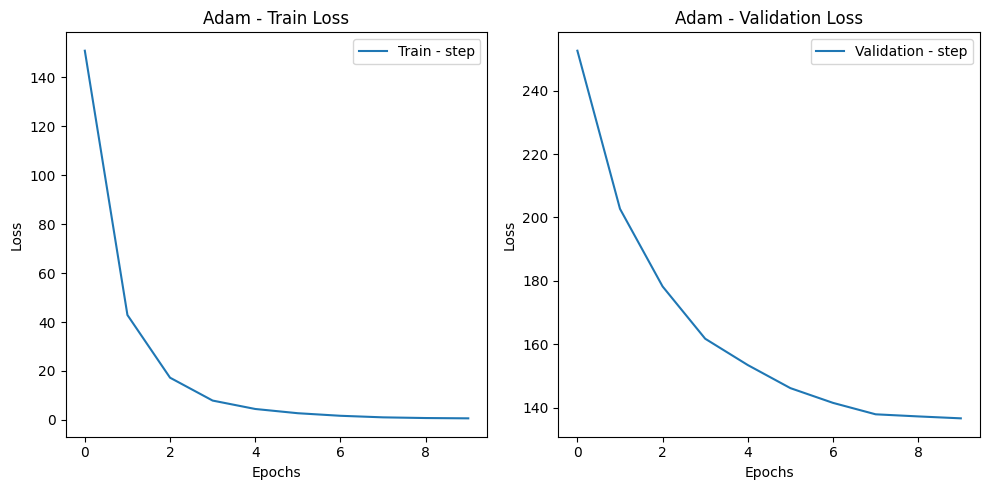

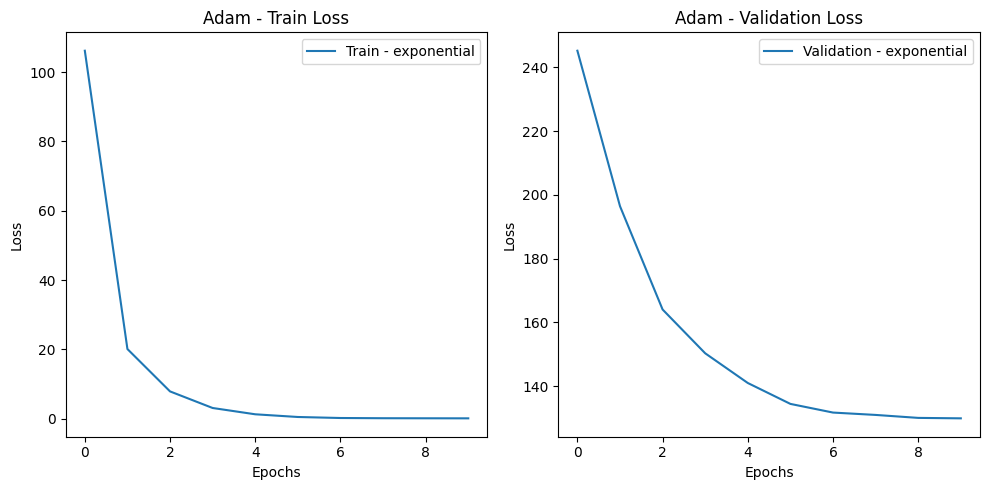

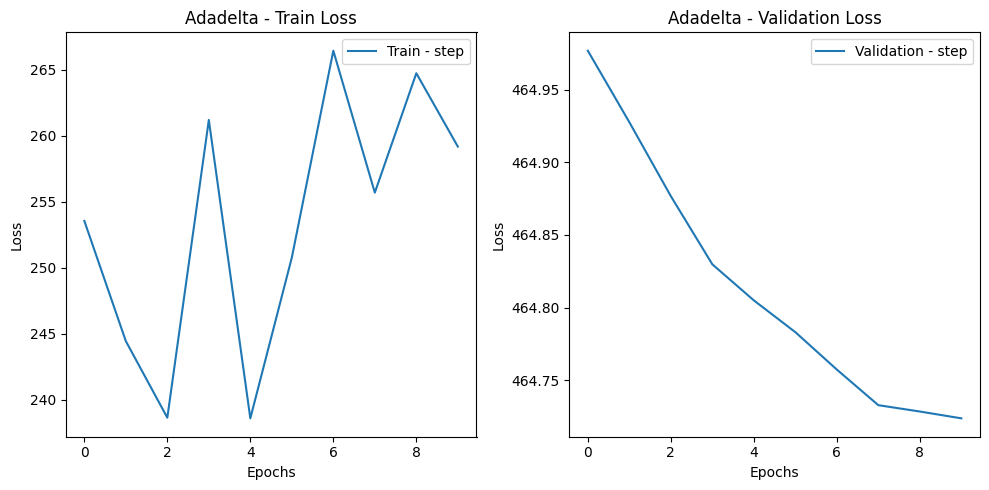

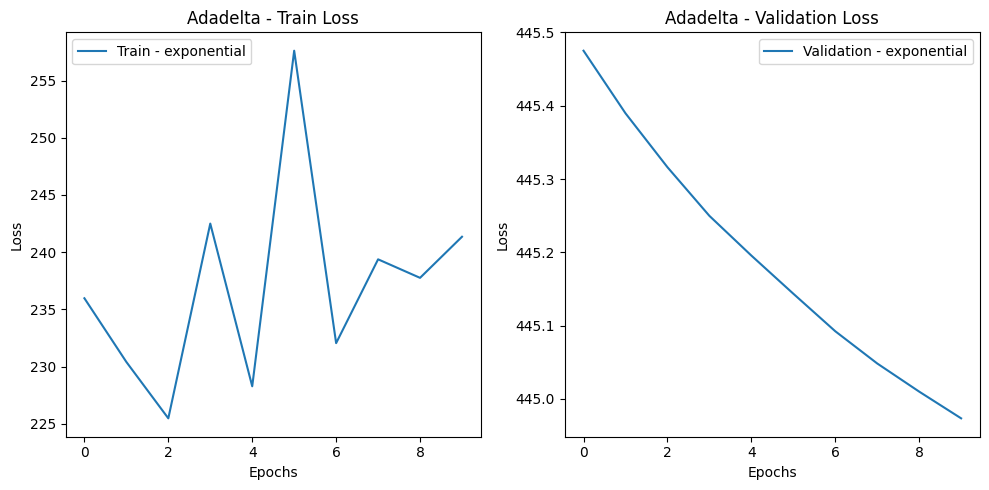

In [63]:
from tensorflow.keras.optimizers import Adam, Adadelta
import matplotlib.pyplot as plt

# Experiment with two different optimizers
optimizers = [Adam, Adadelta]
learning_rate_schedules = ['step', 'exponential']  # Define learning rate schedules here
for optimizer in optimizers:
    for schedule_type in learning_rate_schedules:
        print(f"Optimizer: {optimizer.__name__}, Learning Rate Schedule: {schedule_type}")
        history = train_siamese_model(X_train, y_train, X_val, y_val, total_epochs=total_epochs, batch_size=batch_size, initial_lr=init_lr, schedule_type=schedule_type, optimizer=optimizer)

        # Create a new figure for each combination of optimizer and schedule_type
        if history is not None:
           plt.figure(figsize=(10, 5))

            # Train loss plot
           plt.subplot(1, 2, 1)
           plt.plot(history.history['loss'], label=f'Train - {schedule_type}')
           plt.xlabel('Epochs')
           plt.ylabel('Loss')
           plt.legend()
           plt.title(f'{optimizer.__name__} - Train Loss')

            # Validation loss plot
           plt.subplot(1, 2, 2)
           plt.plot(history.history['val_loss'], label=f'Validation - {schedule_type}')
           plt.xlabel('Epochs')
           plt.ylabel('Loss')
           plt.legend()
           plt.title(f'{optimizer.__name__} - Validation Loss')

           plt.tight_layout()

plt.show()


As can be seen from the above 4 graphs , Adam performs better than Adadelta. Adadelta loss is noisy in nature, as well has higher validation loss. Adam, on the other hand have smooth decrement in loss function and relatively low validation loss.



#### f) Testing the model

In [85]:
print(X_test[:,0].shape)

(56, 224, 224, 3)


In [86]:
print(X_test[:10].shape)
print( y_test_actual[:10])

(10, 2, 224, 224, 3)
[0 0 0 0 0 0 0 0 1 0]


In [87]:
X_test[:,0].shape

(56, 224, 224, 3)

In [98]:
import numpy as np
import matplotlib.pyplot as plt

optimizer = Adam
schedule_type = 'step'
# Define the test set and preprocess it as needed
#X_test, y_test_actual = X_test[:10] ,  y_test_actual[:10]

# Load the trained Siamese model
input_shape = (X_test.shape[2], X_test.shape[3], X_test.shape[4])
siamese_model = create_siamese_model(input_shape)
# Create the left and right input layers
input_left = keras.layers.Input(shape=input_shape)
input_right = keras.layers.Input(shape=input_shape)
# Generate the encodings for both inputs using the same siamese_model
encoded_left = siamese_model(input_left)
encoded_right = siamese_model(input_right)
# Calculate the Euclidean distance between the encodings
distance = keras.layers.Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], ord='euclidean'), output_shape=lambda x: x[0])([encoded_left, encoded_right])
# Create the Siamese model
siamese_net = keras.models.Model(inputs=[input_left, input_right], outputs=distance)
siamese_net.compile(loss=contrastive_loss, optimizer=optimizer(learning_rate=init_lr))

# Load the weights from the best checkpoint during training
siamese_net.load_weights(f'best_{optimizer.__name__}_{schedule_type}_weights.h5')

# Test the model on the test split
test_loss = siamese_net.evaluate([X_test[:, 0], X_test[:, 1]], y_test_actual[:], batch_size = 1)

# Calculate test accuracy based on your threshold
threshold = 15  # Adjust this threshold as needed
distances = siamese_net.predict([X_test[:, 0], X_test[:, 1]], batch_size = 1)
print(f"distances: {distances}")
predictions = [1 if distance < threshold else 0 for distance in distances]
print(f"actual_label: {y_test_actual}")
print(f"predicted_labels: {predictions}")
correct_predictions = np.equal(predictions, y_test_actual)
print(f"num_corr_prediction: {correct_predictions}")
test_accuracy = np.mean(correct_predictions)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


56/56 [==============================] - 1s 15ms/step
distances: [14.953407  15.5334635 19.373629  16.730564  20.5046    14.074921
 15.78233   14.953407  14.316083  16.873957  13.629156  17.628153
 15.817206  16.213354  15.5334635 14.316083  18.737251  16.383842
 20.826593  18.85622   17.725676  19.373629  16.873957  18.737251
 19.44953   18.659948  20.005993  15.573906  16.730564  13.629156
 16.383842  19.44953   19.328773  15.256894  19.051577  20.5046
 17.628153  20.826593  18.659948  19.328773  19.744383  18.844175
 14.074921  15.817206  18.85622   20.005993  15.256894  19.744383
 17.898193  15.78233   16.213354  17.725676  15.573906  19.051577
 18.844175  17.898193 ]
actual_label: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1]
predicted_labels: [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num

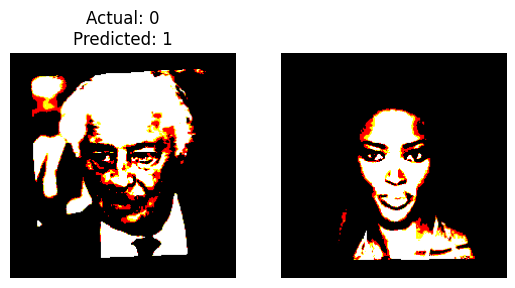

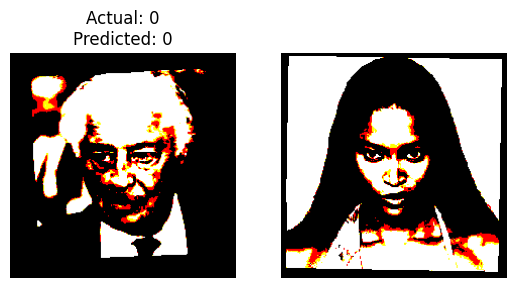

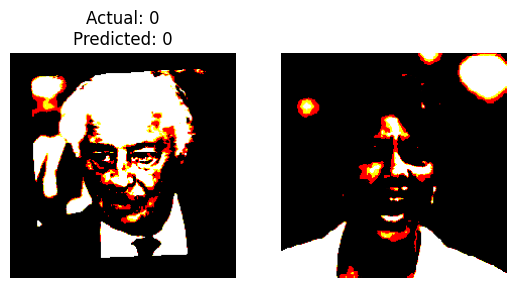

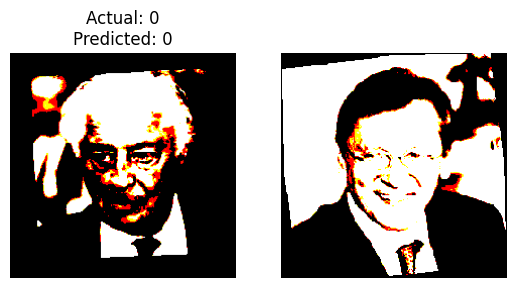

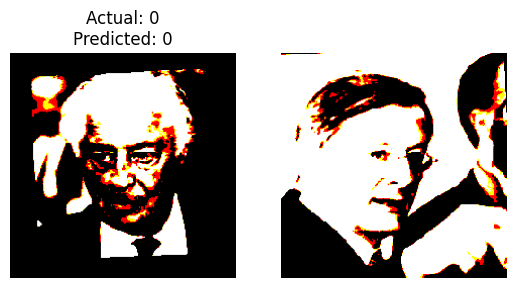

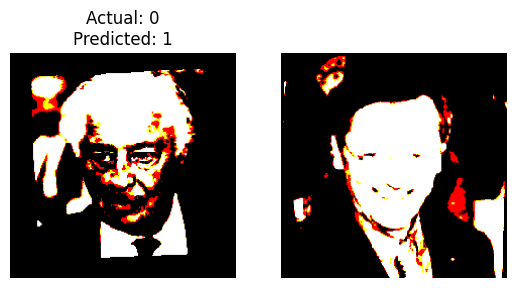

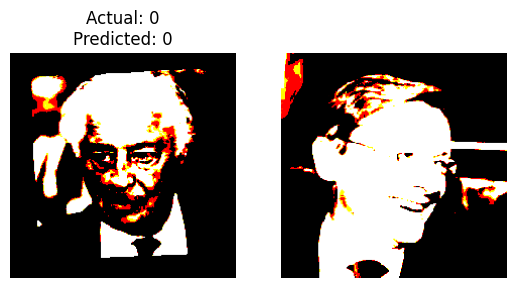

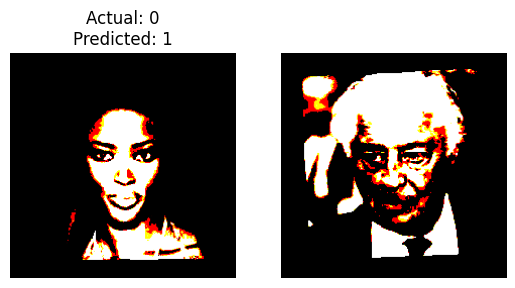

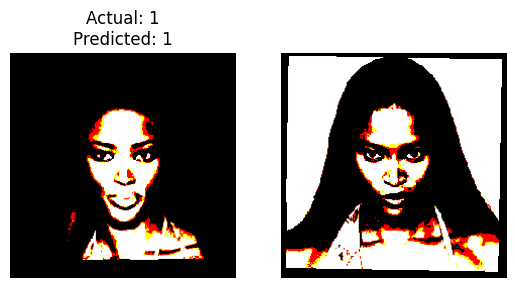

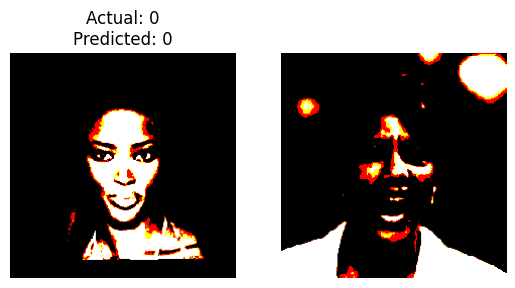

In [99]:
for i in range(10):
    image1 = X_test[i, 0]  # Adjust the index as needed
    image2 = X_test[i, 1]  # Adjust the index as needed
    actual_label = y_test_actual[i]
    predicted_label = predictions[i]

    # Set the title based on actual and predicted labels
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image1,cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2,cmap='gray')
    #plt.title(f"Image 2 - Actual Label: {actual_label}")
    plt.axis('off')

    plt.show()


I have demonstrated Euclidean distance but i strongly believe that Cosine similarity is a better criteria for labeling images .

## Testing on friend's images

In [100]:
import zipfile
zip_file = '/content/drive/MyDrive/ee782_assignments/assignment2/friends.zip'
extract_to = '/content/drive/MyDrive/ee782_assignments/assignment2/friends'
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [112]:
friends = r'/content/drive/MyDrive/ee782_assignments/assignment2/friends/friends'
friends_data,friends_labels = process_directory(friends,4)

In [120]:
pair_data, pair_label = create_pairs(friends_data,friends_labels)
print(pair_label)

[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]


In [124]:
import numpy as np
import matplotlib.pyplot as plt

optimizer = Adam
schedule_type = 'step'
# Define the test set and preprocess it as needed
#X_test, y_test_actual = X_test[:10] ,  y_test_actual[:10]

# Load the trained Siamese model
input_shape = (224,224,3)
siamese_model = create_siamese_model(input_shape)
# Create the left and right input layers
input_left = keras.layers.Input(shape=input_shape)
input_right = keras.layers.Input(shape=input_shape)
# Generate the encodings for both inputs using the same siamese_model
encoded_left = siamese_model(input_left)
encoded_right = siamese_model(input_right)
# Calculate the Euclidean distance between the encodings
distance = keras.layers.Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], ord='euclidean'), output_shape=lambda x: x[0])([encoded_left, encoded_right])
# Create the Siamese model
siamese_net2 = keras.models.Model(inputs=[input_left, input_right], outputs=distance)
siamese_net2.compile(loss=contrastive_loss, optimizer=optimizer(learning_rate=init_lr))

# Load the weights from the best checkpoint during training
siamese_net2.load_weights(f'best_{optimizer.__name__}_{schedule_type}_weights.h5')

# Test the model on the test split
test_loss = siamese_net2.evaluate([pair_data[:, 0], pair_data[:, 1]], pair_label[:], batch_size = 1)

# Calculate test accuracy based on your threshold
threshold2 = 34  # Adjust this threshold as needed
distances = siamese_net.predict([pair_data[:, 0], pair_data[:, 1]], batch_size = 1)
print(f"distances: {distances}")
predictions = [1 if distance < threshold2 else 0 for distance in distances]
print(f"actual_label: {pair_label}")
print(f"predicted_labels: {predictions}")
correct_predictions = np.equal(predictions, pair_label)
print(f"num_corr_prediction: {correct_predictions}")
test_accuracy = np.mean(correct_predictions)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


56/56 [==============================] - 1s 16ms/step
distances: [33.71139  42.617474 36.739925 47.834652 41.385475 37.586243 35.570526
 33.71139  39.788128 23.247665 42.459946 27.991861 19.83654  27.031776
 42.617474 39.788128 38.8771   43.71023  39.499817 39.52016  34.215984
 36.739925 23.247665 38.8771   44.191742 34.00667  24.700272 30.916025
 47.834652 42.459946 43.71023  44.191742 47.859447 45.22804  46.32811
 41.385475 27.991861 39.499817 34.00667  47.859447 26.978674 33.26669
 37.586243 19.83654  39.52016  24.700272 45.22804  26.978674 23.968267
 35.570526 27.031776 34.215984 30.916025 46.32811  33.26669  23.968267]
actual_label: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
predicted_labels: [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
num_corr_prediction: [ True  True  True  True  True 

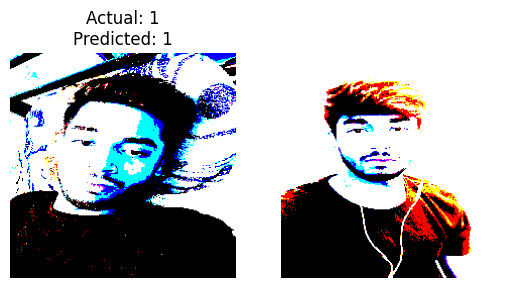

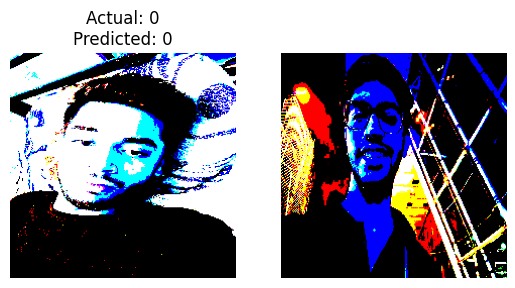

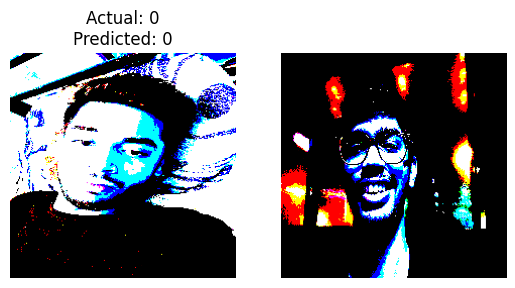

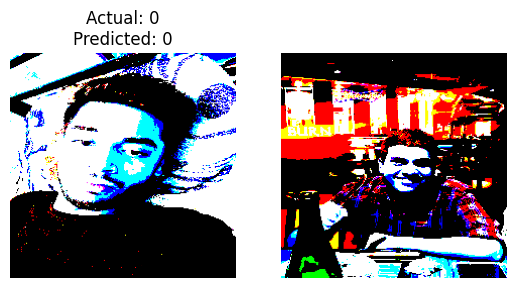

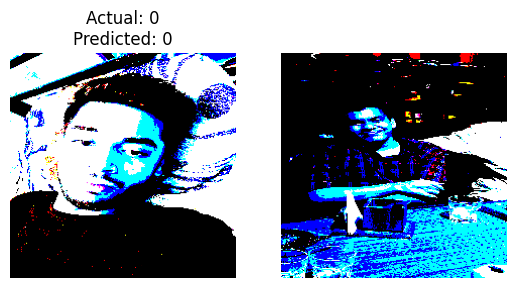

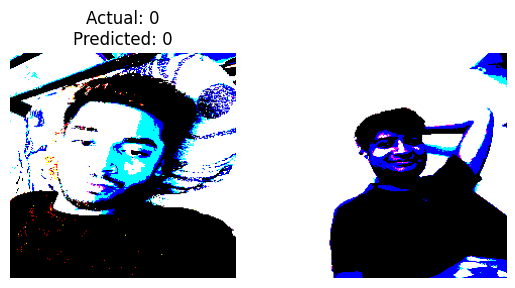

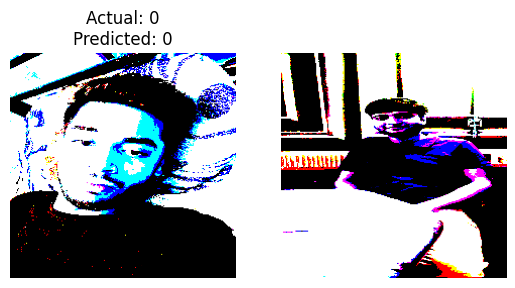

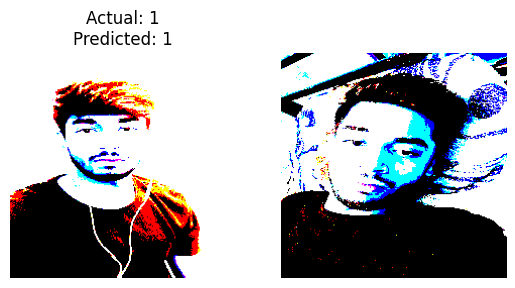

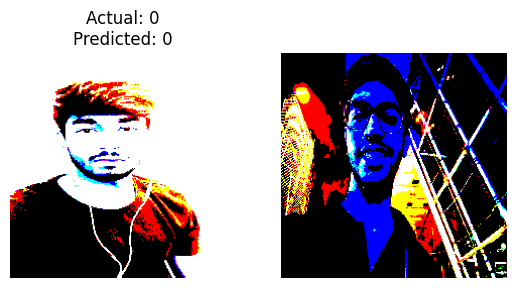

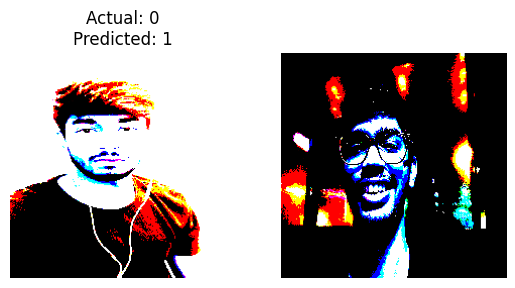

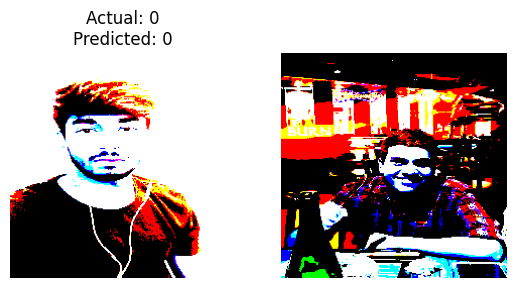

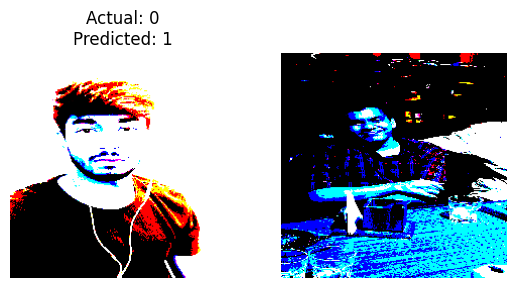

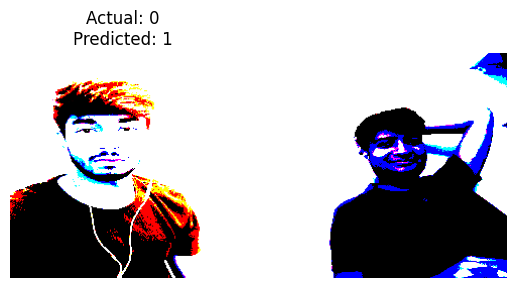

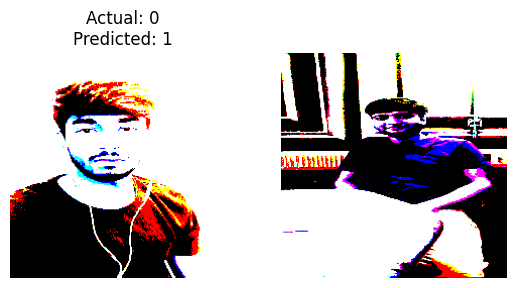

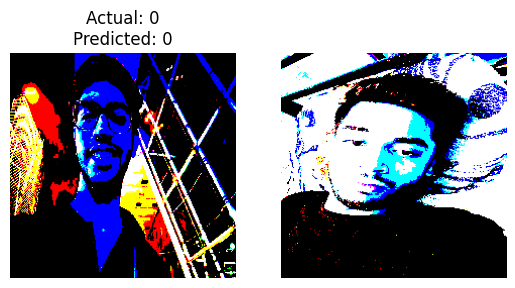

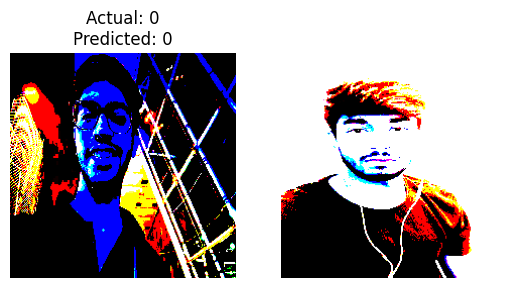

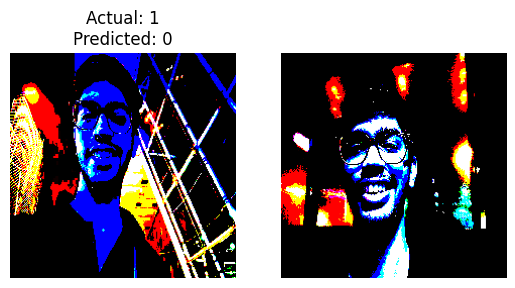

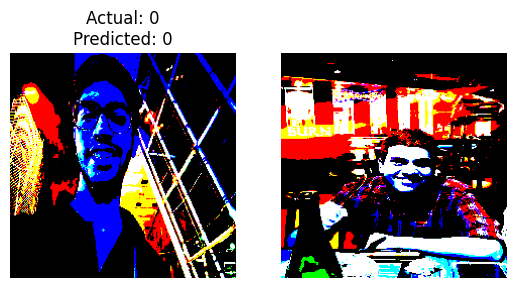

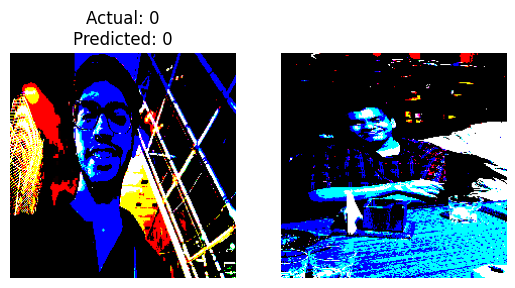

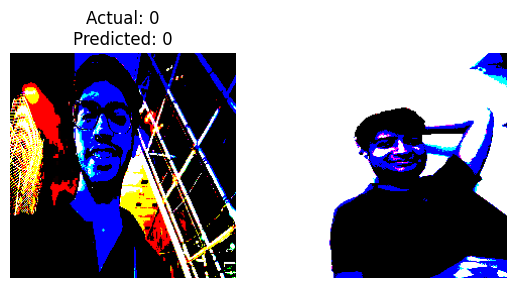

In [125]:
for i in range(20):
    image1 = pair_data[i, 0]  # Adjust the index as needed
    image2 = pair_data[i, 1]  # Adjust the index as needed
    actual_label = pair_label[i]
    predicted_label = predictions[i]

    # Set the title based on actual and predicted labels
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image1,cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2,cmap='gray')
    #plt.title(f"Image 2 - Actual Label: {actual_label}")
    plt.axis('off')

    plt.show()
